<a href="https://colab.research.google.com/github/Hoggnation/cataloging_coherent_oscillators/blob/main/Chi_Squared_Function_on_KIC_7917485.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 63.4 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=d7caaff337c611018204bc394d5fbb045916da695e34abe9c916e5a2537efb0a
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750afe5459f0333c9b
  Created wheel for memoization: filename=memoization-0.4.0-py3-none

In [2]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from astropy import units as u

In [3]:
search_result = lk.search_lightcurve('KIC 7917485', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
#create a delta f (1/tmax-min aka 1/total observation time
#delta_f = 1/lc.time[-1] - lc.time[0] #this is in days
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
print(total_observation_time)
delta_f = (1/total_observation_time) ###frequency resolution in data

1470.4623264496477


In [5]:
#this is cutting off at a low frequency, could be higher freq
sampling_rate_days= np.median(np.diff(lc.time.value))
f_max = 4*(1 / (sampling_rate_days))
print(f_max)

195.75551785296082


In [6]:
f_min = delta_f/3
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

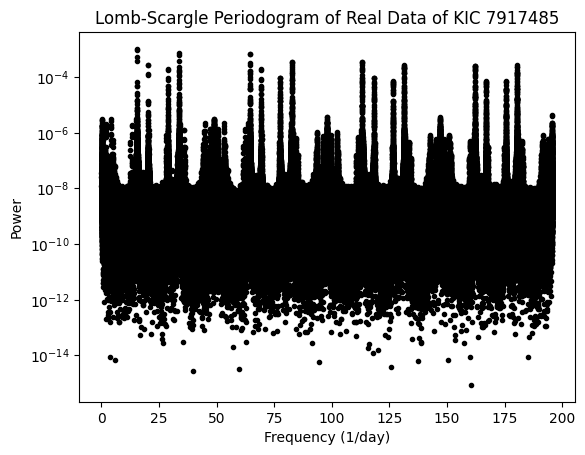

In [7]:
##Doing the same thing with real data

#time is in days


pg_real = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

real_power = pg_real.power.value
real_freq = pg_real.frequency.to(1/u.day).value

plt.plot(real_freq, real_power,'k.')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of Real Data of KIC 7917485")
plt.semilogy()
plt.show()

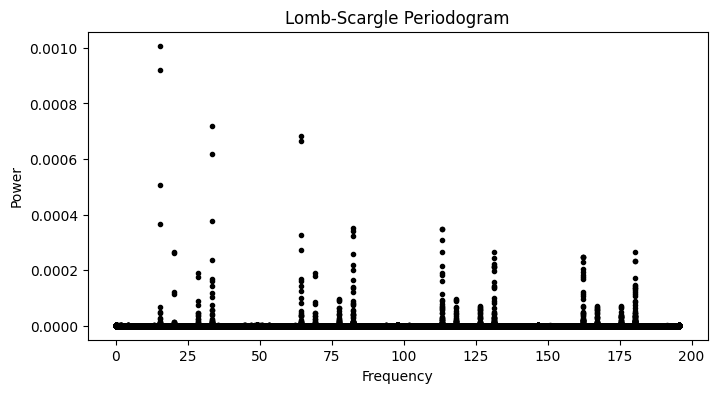

In [8]:
plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(real_freq, real_power, 'k.', lw=0.8)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()

In [9]:
def get_started(num_of_peaks, xs, ys):
    """

    Identifies and returns the indices of the highest peaks in a given dataset.

    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array


    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

In [10]:
def check_inputs(xs):
    """

    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.

    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

In [11]:
def reorder_inputs(xs,ys):
    """

    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length

    """
    i = np.argsort(xs)
    return xs[i], ys[i]


In [12]:
#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist):
    """

    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered

    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

In [13]:
def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak


    Returns:
        tuple: (b, m, q)

    Bugs:
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array


    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

In [14]:
def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak

    Returns:
        tuple: (x position of refined peak, y position of refined peak)

    Bugs:
        Must be synchronized with the design matrix


    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b

In [15]:
indices = get_started(10, real_freq, real_power)
print(indices)

[ 67859 148028 283748 363928 499625 499649 363905 579794 795671  89386]


In [17]:
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        tuple of numpy arrays (array of refined x positions, array of refined y positions


    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined)

In [18]:
new_freqs, new_powers = refine_peaks(real_freq, real_power, indices) # this returns the new x values
#and the new y values

In [19]:
print (new_freqs, new_powers)

[ 15.3829968   33.5560519   64.32204886  82.497657   113.25832561
 113.26366998  82.49233212 131.43139707 180.36769562  20.26289502] [0.0010443  0.0007357  0.00072256 0.00035157 0.00035916 0.00035085
 0.00035772 0.00027113 0.00027293 0.000282  ]


In [20]:
#originally the new positions function was returning the refined peaks and powers as seperate arrays, now they are arranged as tuples so that the zip function works
new_freqs, new_powers = refine_peaks(real_freq, real_power, indices)
new_positions = list(zip(new_freqs, new_powers))
refined_frequencies, refined_powers = zip(*new_positions)

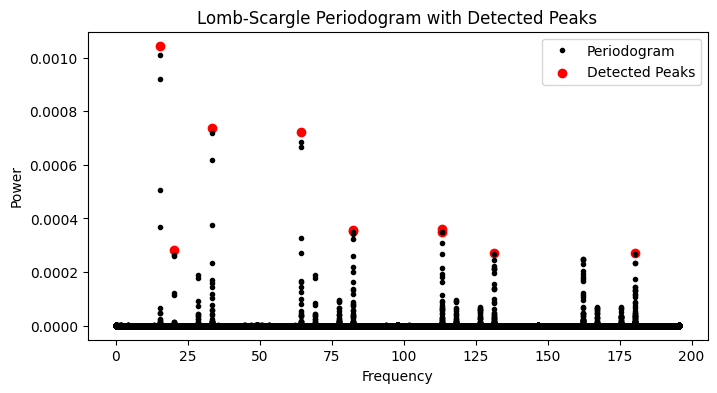

In [21]:
plt.figure(figsize=(8, 4))

plt.plot(real_freq, real_power, 'k.', lw=0.8, label="Periodogram")

plt.scatter(refined_frequencies, refined_powers, color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram with Detected Peaks")
plt.legend()

plt.show()

In [22]:
# Arrays for time, flux, uncertainity, and selecting our frequency from the refined peaks
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value
max_power_index = np.argmax(new_powers)
nu = new_freqs[max_power_index]

In [23]:
print(nu)

15.382996803505382


In [24]:
print(t.shape, flux.shape, sigma.shape)

(65504,) (65504,) (65504,)


In [25]:
# Masking the arrays to ensure all arrays are the same length(had error due to unmatched data lengths)
t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean) #good

lc = lc[mask]
t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]

In [26]:
print(len(lc), t_fit.shape, flux_fit.shape, sigma_fit.shape)

65266 (65266,) (65266,) (65266,)


In [27]:
print(t_fit.max(), flux_fit.max(), sigma_fit.max())

1591.0007908573243 1.0161732 0.00012699235


In [28]:
lc_exptime = (6.52 * 270) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1

omega = 2 * np.pi * nu

# Design matrix

def easy_design_matrix(ts, om):
    return np.vstack([
        np.ones_like(ts),
        np.cos(om * ts),
        np.sin(om * ts)
    ]).T

def integral_design_matrix(ts, om, T):
    """
    ##bugs:
    - assumes all data points have the same exposure time, `T`
    - not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (+ np.sin(om * (ts + T/2)) - np.sin(om * (ts - T/2))) / (om * T),
        (- np.cos(om * (ts + T/2)) + np.cos(om * (ts - T/2))) / (om * T)
    ]).T

A_easy = easy_design_matrix(t_fit, omega)

A_integral = integral_design_matrix(t_fit, omega, lc_exptime)

print(A_easy, A_integral, A_easy - A_integral)


[[ 1.          0.0451439   0.99898049]
 [ 1.         -0.93620424 -0.35145643]
 [ 1.          0.69138352 -0.72248794]
 ...
 [ 1.         -0.11663749 -0.99317455]
 [ 1.          0.9589939   0.28342672]
 [ 1.         -0.63781185  0.77019221]] [[ 1.          0.0381945   0.84519866]
 [ 1.         -0.7920861  -0.29735366]
 [ 1.          0.58495279 -0.61126903]
 ...
 [ 1.         -0.09868246 -0.84028648]
 [ 1.          0.81136755  0.23979636]
 [ 1.         -0.53962788  0.65162976]] [[ 0.          0.0069494   0.15378183]
 [ 0.         -0.14411813 -0.05410277]
 [ 0.          0.10643073 -0.11121891]
 ...
 [ 0.         -0.01795503 -0.15288808]
 [ 0.          0.14762635  0.04363036]
 [ 0.         -0.09818398  0.11856245]]


In [31]:
weight_fit = 1 / sigma_fit**2

def weighted_least_squares(A, b, weights):
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return np.linalg.solve(ATA, ATb), ATA    #returns coefficients and inverse uncertainity

y_hat = A_integral @ weighted_least_squares(A_integral, flux_fit, weight_fit)[0]

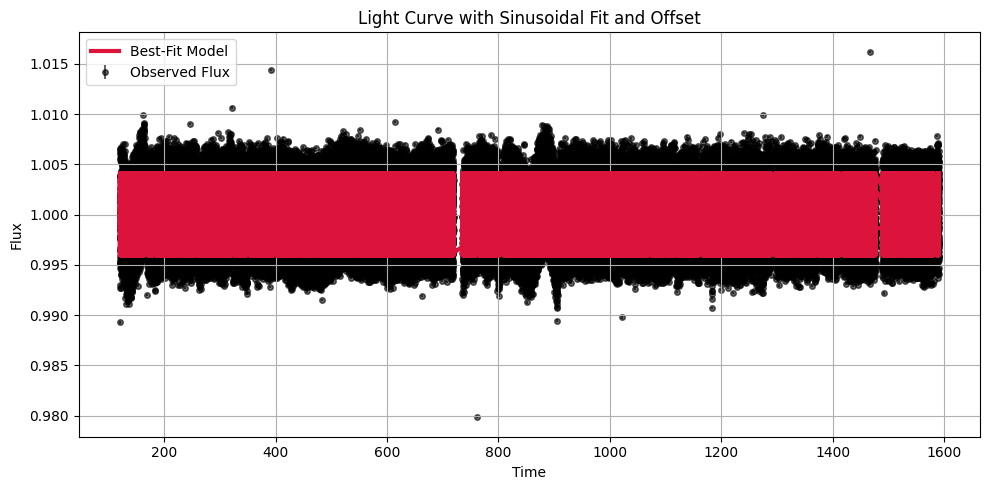

In [32]:
plt.figure(figsize=(10, 5))

# Plot observed flux (data)
plt.errorbar(
    t_fit, flux_fit, yerr=sigma_fit, fmt='o',
    label='Observed Flux', alpha=0.6, color='black', markersize=4, zorder=1
)

# Plot best-fit model (bold and on top)
plt.plot(
    t_fit, y_hat, color='crimson',
    label='Best-Fit Model', linewidth=3, zorder=2
)

# Labels and styling
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Light Curve with Sinusoidal Fit and Offset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

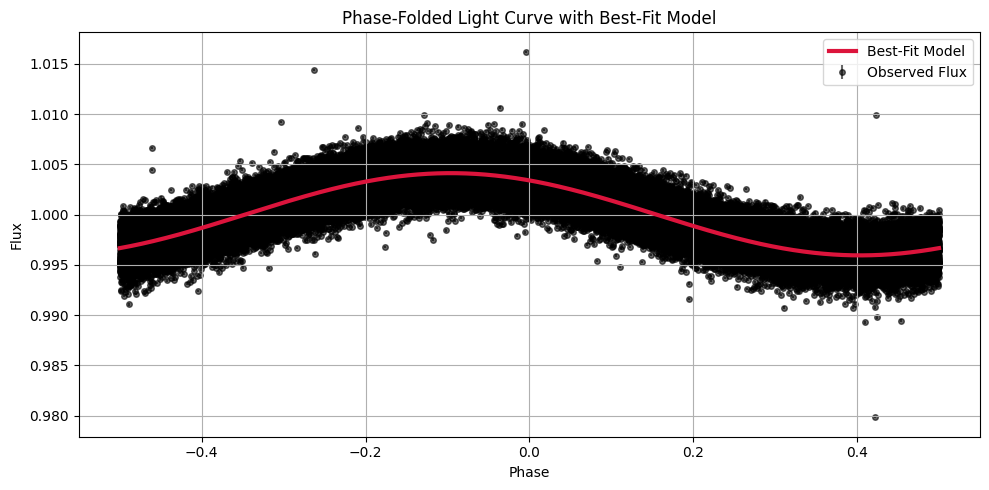

In [33]:
# Compute period from selected frequency
P = 1 / new_freqs[max_power_index]

# Reference time
t0 = t_fit[np.argmin(flux)] #this should center the phase around zero?

# phase folding over the select period
phase = ((t_fit - t0) % P) / P
phase[phase > 0.5] -= 1 # shifting range


# Sort for better plotting // i think data may already be sorted
sorted_indices = np.argsort(phase)
phase_sorted = phase[sorted_indices]
flux_sorted = flux_fit[sorted_indices]
sigma_sorted = sigma_fit[sorted_indices]
model_sorted = y_hat[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(
    phase_sorted, flux_sorted, yerr=sigma_sorted, fmt='o',
    label='Observed Flux', alpha=0.6, color='black', markersize=4, zorder=1
)
plt.plot(
    phase_sorted, model_sorted, color='crimson',
    label='Best-Fit Model', linewidth=3, zorder=2
)

# Labels and styling
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Phase-Folded Light Curve with Best-Fit Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



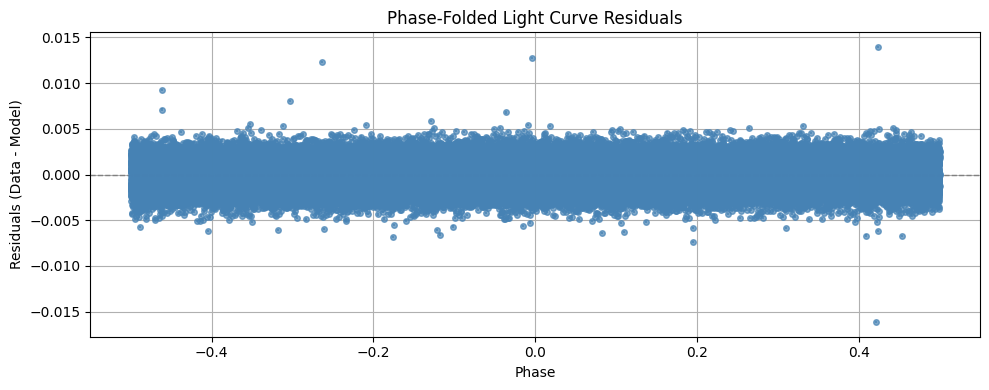

In [34]:
# Calculate residuals
residuals = flux_sorted - model_sorted

# Plot residuals
plt.figure(figsize=(10, 4))
plt.errorbar(
    phase_sorted, residuals, yerr=sigma_sorted, fmt='o',
    color='steelblue', alpha=0.7, markersize=4
)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Labels and styling
plt.xlabel('Phase')
plt.ylabel('Residuals (Data - Model)')
plt.title('Phase-Folded Light Curve Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    pars, invar = weighted_least_squares(A, ys, ws)
    return np.sum(ws * (ys - A @ pars)**2)

# Step 1: Define fine frequency grid around best_nu (extended range)
fine_freqs = np.arange(nu - 5 * f_min, nu + 5 * f_min, 0.2 * f_min)  # Adjusted range around nu
chi2_fine = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqs])

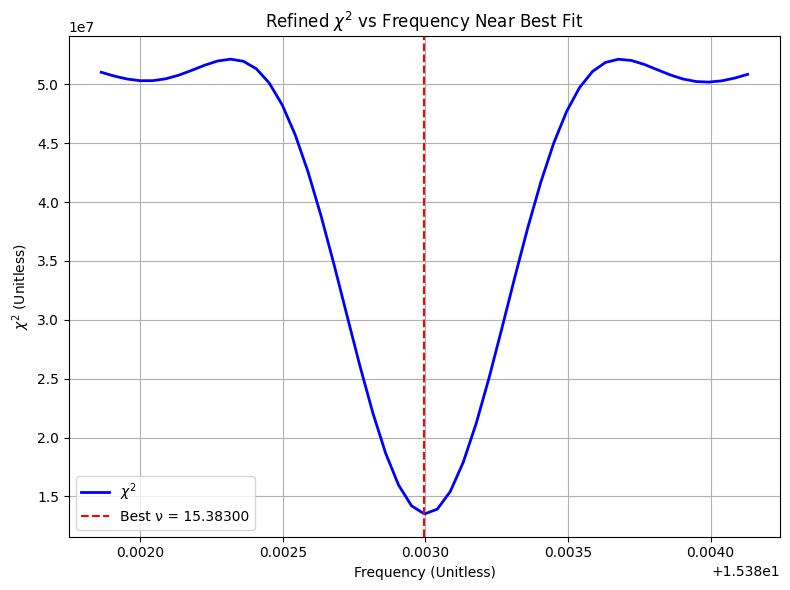

In [36]:
    # Step 3: Plot refined chi^2 vs frequency
plt.figure(figsize=(8, 6))
plt.plot(fine_freqs, chi2_fine, 'b-', lw=2, label=r"$\chi^2$")
plt.axvline(nu, color='red', linestyle='--', label=f'Best ν = {nu:.5f}')

# Labels and title
plt.xlabel("Frequency (Unitless)")
plt.ylabel(r"$\chi^2$ (Unitless)")
plt.title(r"Refined $\chi^2$ vs Frequency Near Best Fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
def check_coherence(ts, ys, weights, om):
    """
    assumes a lot of things about the data
    """
    cases = [(np.ones_like(ts).astype(bool), "all"),
             (ts < np.median(ts), "early"),
             (ts > np.median(ts), "late")]
    for I, name in cases:
        A = integral_design_matrix(ts[I], om, lc_exptime)
        pars, invar = weighted_least_squares(A, ys[I], weights[I])
        print(name, pars, invar)

In [47]:
check_coherence(t_fit, flux_fit, weight_fit, 2. * np.pi * nu)

all [ 1.00003296 -0.00321891  0.00360325] [[ 4.62420867e+12  2.78398676e+09 -3.64779980e+09]
 [ 2.78398676e+09  1.65469792e+12  3.86618936e+08]
 [-3.64779980e+09  3.86618936e+08  1.65540126e+12]]
early [ 1.00001858 -0.00325639  0.00356639] [[ 2.35594838e+12  1.64314835e+09 -1.67287150e+09]
 [ 1.64314835e+09  8.43311649e+11  1.52534788e+08]
 [-1.67287150e+09  1.52534788e+08  8.43122369e+11]]
late [ 1.00004791 -0.00317994  0.00364151] [[ 2.26826029e+12  1.14083841e+09 -1.97492831e+09]
 [ 1.14083841e+09  8.11386271e+11  2.34084148e+08]
 [-1.97492831e+09  2.34084148e+08  8.12278890e+11]]
